In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import pickle

from sl_model import SL512, DSODSL512
from ssd_data import InputGenerator
from ssd_data import preprocess
from ssd_utils import load_weights

Using TensorFlow backend.


In [2]:
model = SL512()
weights_path = './checkpoints/201711101623_sl512_synthtext_hardN/weights.001.h5'
segment_threshold = 0.7; link_threshold = 0.5

#weights_path = './checkpoints/201711071436_sl512_synthtext/weights.001.h5'
#segment_threshold = 0.71; link_threshold = 0.57

#weights_path = './checkpoints/201710242216_sl512_synthtext/weights.002.h5'
#segment_threshold = 0.60; link_threshold = 0.50
plot_name = 'sl512_sythtext'

In [3]:
model = DSODSL512()
weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.001.h5'
segment_threshold = 0.55; link_threshold = 0.45
plot_name = 'dsodsl512_sythtext'

In [4]:
image_size = model.image_size
load_weights(model, weights_path)

from sl_utils import PriorUtil
prior_util = PriorUtil(model)

### SynthText

In [5]:
from data_synthtext import GTUtility

with open('gt_util_synthtext_seglink.pkl', 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.9)

In [6]:
_, inputs, images, data = gt_util_val.sample_random_batch(batch_size=16, input_size=image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

16/16 [==============================] - 3s 200ms/step


./checkpoints/201711132011_dsodsl512_synthtext


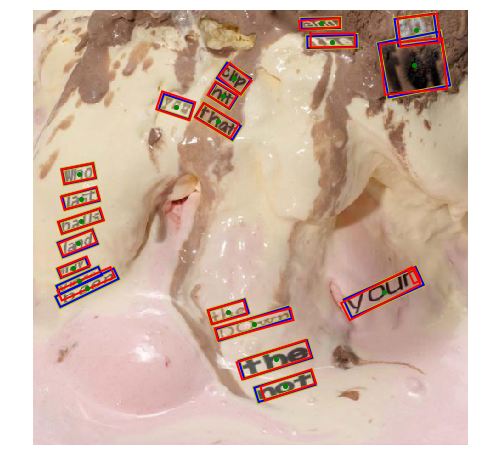

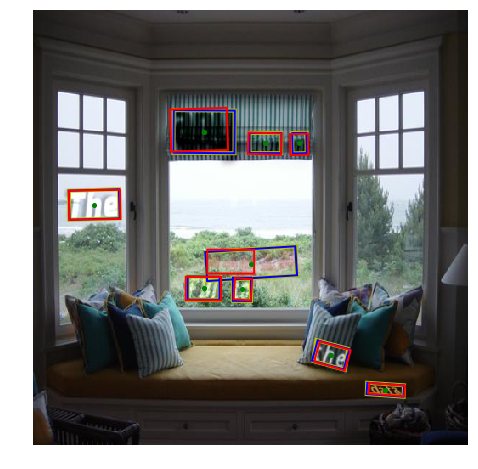

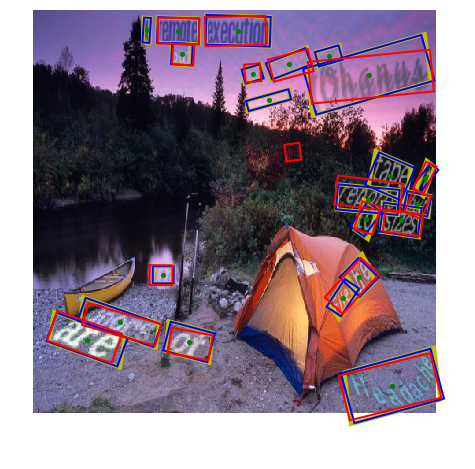

In [7]:
checkdir = os.path.dirname(weights_path)
print(checkdir)

for fl in glob.glob('%s/result_*' % (checkdir,)):
    #os.remove(fl)
    pass

for i in range(3):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold, debug=False)
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(res)
    plt.axis('off')
    #plt.savefig('%s/result_%03d.jpg' % (checkdir, i))
    plt.show()

### Real world images

In [8]:
inputs = []
images = []

for img_path in glob.glob('data/images/test_images_seglink/*'):
    img = cv2.imread(img_path)
    inputs.append(preprocess(img, image_size))
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
inputs = np.asarray(inputs)

preds = model.predict(inputs, batch_size=1, verbose=1)

25/25 [==============================] - 1s 41ms/step


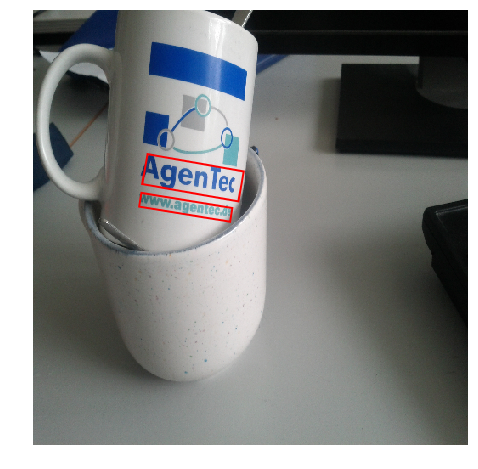

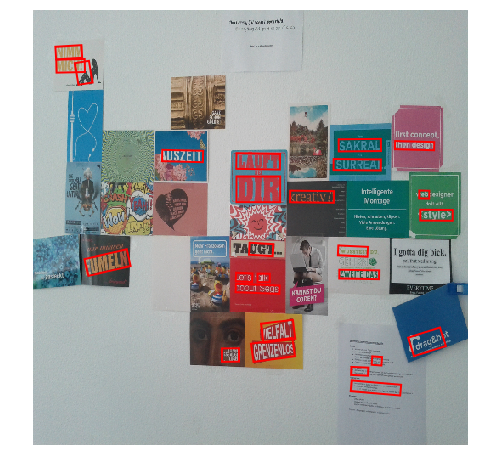

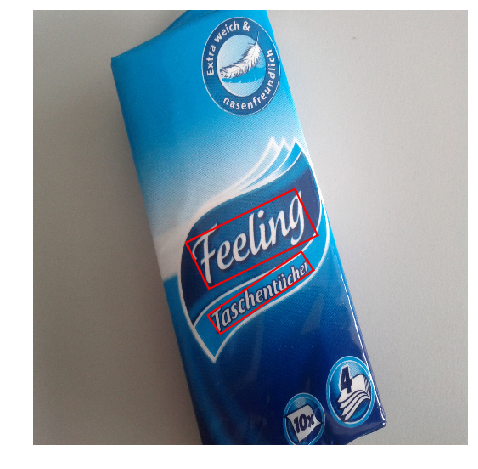

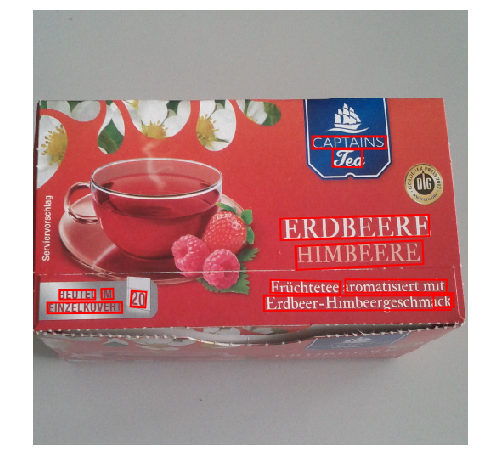

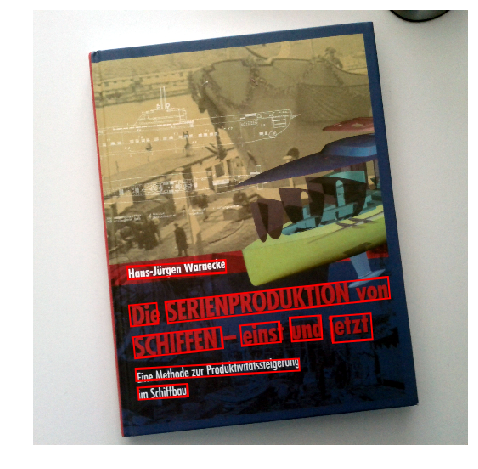

In [9]:
#for fl in glob.glob('%s/result_*' % (checkdir,)):
#    os.remove(fl)

for i in [2, 3, 9, 10, 24]:
    plt.figure(figsize=[8]*2, frameon=True)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold)
    prior_util.plot_results(res)
    plt.axis('off')
    #plt.savefig('%s/result_%03d.pgf' % (checkdir, i), bbox_inches='tight')
    #plt.savefig('plots/%s_result_%03d.pgf' % (plot_name, i), bbox_inches='tight')
    plt.show()